In [270]:
import os
import pandas as pd
import plotting
import importlib
importlib.reload(plotting)
import math
import numpy as np

# Load in all depth vs resistance curves into a dataframe list

In [271]:
def load_data(data_src):
    depth_resist_curve_df_list = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        depth_resist_curve_df_list.append(df)
        filename_list.append(filename)
    return depth_resist_curve_df_list, filename_list

data_src = "data/cleaned_data"
depth_resist_curve_df_list, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, depth_resist_curve_df_list))

# Seperate clustering data from meta-data

In [272]:
data_features_df = pd.read_csv("data/features.csv")
metadata_list = ['filenames', 'feifeis_ylabels', 'liams_ylabels', 'marions_ylabels', 'distances']
clustering_features_df = data_features_df.drop(metadata_list, axis=1)

# Clustering FeiFei's Labels

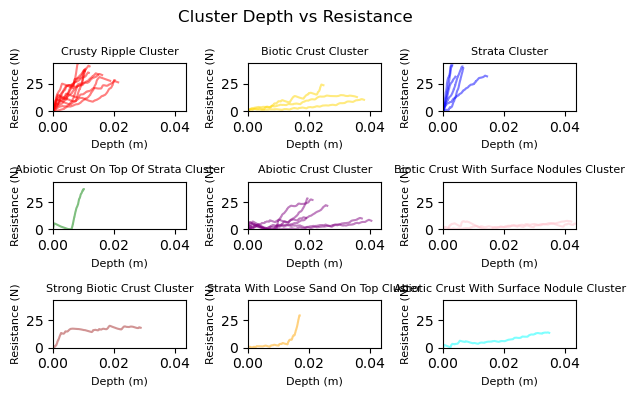

In [273]:
feifeis_features_df = data_features_df[data_features_df['feifeis_ylabels'].notna()].copy() # removes NaN's which correspond to non-labled data
feifeis_features_df['encoded'], uniques = pd.factorize(feifeis_features_df['feifeis_ylabels'])
y_labels = feifeis_features_df['encoded'].to_list()
plotting.plot_clusters_seperately(y_labels, feifeis_features_df.index, depth_resist_curve_df_list, data_features_df, cluster_category_names=uniques.to_list(), filenames=False)

data_features_df[['filenames', 'feifeis_ylabels']][data_features_df['feifeis_ylabels'] == 'crusty ripple'].to_csv('filename_feiei_label.csv')

# Clustering Liam's Labels

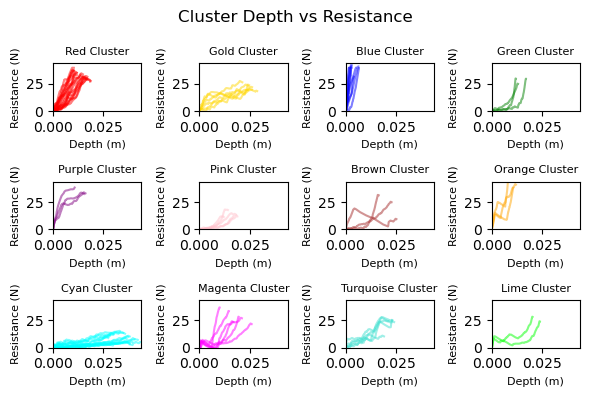

In [274]:
# plot_clusters_together(y_labels=data_features_df['liams_ylabels'])
plotting.plot_clusters_seperately(data_features_df['liams_ylabels'], data_features_df.index.tolist(), depth_resist_curve_df_list, data_features_df)

# Clustering Marion's Labels

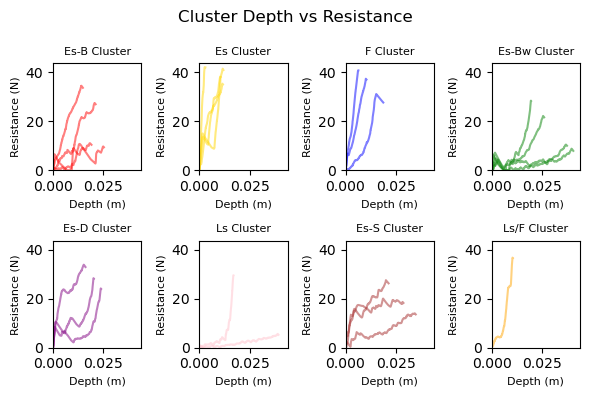

Index([0, 26, 39, 49], dtype='int64')
Index([8, 25, 48, 71], dtype='int64')


In [ ]:
marions_features_df = data_features_df[data_features_df['marions_ylabels'].notna()].copy() # removes NaN's which correspond to non-labled data
# encodes object into categorical variables
marions_features_df['encoded'], uniques = pd.factorize(marions_features_df['marions_ylabels'])
plotting.plot_clusters_seperately(marions_features_df['encoded'].tolist(), marions_features_df.index.tolist(), depth_resist_curve_df_list, data_features_df, 
                         cluster_category_names=uniques.tolist())
non_features_cols = ['filenames', 'feifeis_ylabels', 'liams_ylabels', 'marions_ylabels', 'distances', 'encoded']
plotting.plot_pca(marions_features_df.drop(non_features_cols, axis=1), marions_features_df['encoded'], 3, graph_title='marions_ylabels')

# def print_color_to_index_mapping()
print(marions_features_df[marions_features_df['encoded'] == 0].index)
print(marions_features_df[marions_features_df['encoded'] == 1].index)


# Using Marion's label means as centroids assigning nearest curves to point

In [276]:
def find_marions_labels_feature_means(marions_features_df: pd.DataFrame) -> pd.DataFrame:
    meta_data_cols = ['filenames', 'feifeis_ylabels', 'liams_ylabels', 'distances']
    marions_features_df = marions_features_df.drop(meta_data_cols, axis=1)
    marions_labels_mean_df = pd.DataFrame(columns=marions_features_df.columns)
    for label_num, label_name in enumerate(uniques):
        label_features = marions_features_df[marions_features_df['encoded'] == label_num]
        mean_series = label_features.drop(['encoded', 'marions_ylabels'], axis=1).mean(axis=0) # drop cols for mean calculation
        label_features_mean_df = pd.DataFrame([mean_series], columns=marions_features_df.columns)
        label_features_mean_df['marions_ylabels'] = label_name
        label_features_mean_df['encoded'] = label_num
        marions_labels_mean_df = pd.concat([marions_labels_mean_df, label_features_mean_df], axis=0)
    return marions_labels_mean_df.reset_index().drop('index', axis=1)

marions_labels_mean_df = find_marions_labels_feature_means(marions_features_df)

def euclidean_distance(x: pd.DataFrame, y: pd.DataFrame) -> float:
    inner_sum = 0
    for idx in range(len(x)):
        inner_sum += (y.iloc[idx] - x.iloc[idx])**2
    return math.sqrt(inner_sum)

psuedo_label_list = []
psuedo_labeled_features_df = clustering_features_df.copy()
for i, depth_res_curve in psuedo_labeled_features_df.iterrows():
    min_distance = float('inf')
    min_distance_label = ''
    for j, marions_label_mean in marions_features_df.iterrows():
        curve_to_label_mean_distance = euclidean_distance(depth_res_curve, marions_label_mean)
        if curve_to_label_mean_distance < min_distance:
            min_distance = curve_to_label_mean_distance
            min_distance_label = marions_label_mean['marions_ylabels']
    psuedo_label_list.append(min_distance_label)
psuedo_labeled_features_df['marions_pseudo_labels'] = psuedo_label_list


psuedo_labeled_features_df['encoded'], uniques = pd.factorize(psuedo_labeled_features_df['marions_pseudo_labels'])
plotting.plot_pca(clustering_features_df, psuedo_labeled_features_df['encoded'], 3, 
                  graph_title='marions_psuedo_labels', kmeans_centroids=marions_labels_mean_df.drop(['marions_ylabels', 'encoded'], axis=1))



/tmp/ipykernel_118017/1032020270.py:11: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

